**Chapter 18 – Reinforcement Learning**

_This notebook contains all the sample code and solutions to the exercises in chapter 18._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/18_reinforcement_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/18_reinforcement_learning.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.7 or above:

In [6]:
import sys #"This module provides access to some 
#variables used or maintained by the interpreter and to functions 
#that interact strongly with the interpreter. It is always available" by (DevDocs.io).
#comentar de donde saque esta info 
assert sys.version_info >= (3, 7)#I'm just asking what version of sys is the one I have.

And TensorFlow ≥ 2.8:

In [7]:
from packaging import version# This module provides utilities for parsing and comparing version numbers.
import tensorflow as tf
# "TensorFlow is an open-source machine learning framework developed by Google.
# It provides tools for building and training machine learning models" by (DevDocs.io).
assert version.parse(tf.__version__) >= version.parse("2.8.0")# to convert the strings of 
#"version into Version objects and compares the TensorFlow version with the specified version ("2.8.0")". by (DevDocs.io).
#this because if it is lower it does not run

As we did in earlier chapters, let's define the default font sizes to make the figures prettier. We will also display some Matplotlib animations, and there are several possible options to do that: we will use the Javascript option.

In [8]:
import matplotlib.animation#"The easiest way to make a live animation in Matplotlib is to use one of the Animation classes.
#in order to generate the stick animation" by (DevDocs.io).
import matplotlib.pyplot as plt
#"is a state-based interface to matplotlib. It provides an implicit, MATLAB-like, 
#way of plotting. It also opens figures on your screen, and acts as the figure GUI manager.
#pyplot is mainly intended for interactive plots and simple cases of programmatic plot generation"(DevDocs.io).
plt.rc('font', size=14)#default font size in 14 for the text
plt.rc('axes', labelsize=14, titlesize=14)#Sets the default size of 
#font for axis labels and chart titles to 14
plt.rc('legend', fontsize=14)#for legend in 14
plt.rc('xtick', labelsize=10)#default font size for x-axis labels in 10
plt.rc('ytick', labelsize=10)#default font size for y-axis labels in 10
plt.rc('animation', html='jshtml')#Configure the output of animations in HTML format using JavaScript and HTML
#This can be useful for displaying animations in a Jupyter notebook environment

And let's create the `images/rl` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [9]:
from pathlib import Path#"This module offers classes representing filesystem paths with 
#semantics appropriate for different operating systems. Path classes are divided between pure paths, 
#which provide purely computational operations without I/O, 
#and concrete paths, which inherit from pure paths but also provide I/O operations" by (DevDocs.io).

IMAGES_PATH = Path() / "images" / "rl" #Crea un objeto Ruta que representa la ruta al directorio de imágenes de aprendizaje por refuerzo. 
#La ruta se construye concatenando los componentes de la ruta utilizando el operador "/".
IMAGES_PATH.mkdir(parents=True, exist_ok=True)#Creates the directory specified by 
#PICTURE_ROADS in the file system. The arguments 
#parents=True and existence_ok=True tell mkdir to create all missing directories in the path (if necessary) and not to generate an error if the directory already exists. 
#(if necessary) and not to generate an error if the directory already exists

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    """    
Saves the current Matplotlib figure with the given figure ID.

 Parameters:
    - fig_id (str): The unique identifier for the figure.
    - tight_layout (bool): Whether to adjust the subplot parameters to give a specified fill.
 specified fill. The default value is True.
    - fig_extension (str): The file extension for the saved figure. The default is "png".
    - resolución (int): The resolution of the figure saved in dots per inch (DPI).
 The default value is 300.

 Returns:
    None
"""
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"#Constructs the full path to the 
    #image file using the image directory PATHWAYS_IMAGES, 
    #the figure ID figure_id, and the file extension figure_extension 
    if tight_layout:#Checks if the set_adjusted_adjustment argument is true
        plt.tight_layout()# If fit_adjusted is true, it automatically adjusts 
        #the subplot parameters so that axes or labels do not overlap with adjacent 
        #objects in the figure, which improves the appearance of the final figure
    plt.savefig(path, format=fig_extension, dpi=resolution)#  Saves the current Matplotlib figure 
    #to the file specified by path. The format and dpi parameters 
    #control the file format and resolution of the saved image, respectively
 

This chapter can be very slow without a GPU, so let's make sure there's one, or else issue a warning:

In [10]:
if not tf.config.list_physical_devices('GPU'):# Use tf.config.list_physical_devices 
    #to list the physical devices available to TensorFlow and check if a GPU is not detected
    print("No GPU was detected. Neural nets can be very slow without a GPU.")# Prints a message informing the user 
    #that a GPU was not detected and that neural networks can be very slow without a GPU
    if "google.colab" in sys.modules:#  Checks if the google.colab module is loaded
        #This indicates that the code is running in Google Colab, a cloud-based Python environment
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")# If the code is running in Google Colab, it prints a message 
        #prompting the user to go to the runtime settings and select a GPU hardware accelerator
    if "kaggle_secrets" in sys.modules:#  Checks if the kaggle_secrets module is loaded This indicates that the code is running on Kaggle, 
        #an online platform for data science and machine learning
        print("Go to Settings > Accelerator and select GPU.")# If the code is running in Kaggle, 
        #it prints a message prompting the user to go to settings and select a GPU accelerator

No GPU was detected. Neural nets can be very slow without a GPU.


Let's install the Gymnasium library, which provides many environments for Reinforcement Learning. We'll also install the extra libraries needed for classic control environments (including CartPole, which we will use shortly), as well as for Box2D and Atari environments, which are needed for the exercises.

**Important notes:**
* OpenAI has handed over the maintenance and developmnent of the Gym library to the Farama foundation (see the [announcement](https://farama.org/Announcing-The-Farama-Foundation)), and the library was renamed to Gymnasium. It's a drop-in replacement for OpenAI Gym: you can just install `gymnasium` instead of `gym`, and `import gymnasium as gym`, and everything should work fine.
* by running the following cell, you accept the Atari ROM license.

In [11]:
#nothing helps me here, since I'm working on jupyter
if "google.colab" in sys.modules or "kaggle_secrets" in sys.modules:
    %pip install -q -U gymnasium swig
    %pip install -q -U gymnasium[classic_control,box2d,atari,accept-rom-license]

# Introduction to ~OpenAI gym~ Gymnasium

In this notebook we will be using [gymnasium](https://github.com/Farama-Foundation/Gymnasium), a great toolkit for developing and comparing Reinforcement Learning algorithms. It provides many environments for your learning *agents* to interact with. Let's import Gym and make a new CartPole environment:

In [12]:
import gymnasium as gym #he is commenting above 

env = gym.make("CartPole-v1", render_mode="rgb_array")
"""
gym.make("CartPole-v1"): Creates an instance of the CartPole-v1 
environment in OpenAI Gym. The CartPole is a classic control 
problem where you try to balance a pole on a cart moving horizontally
render_mode="rgb_array": This optional argument specifies that we want 
to render the environment in an RGB format in order to capture the image 
for further processing. This is useful when you want to visually track 
the environment, for example, to visualize a reinforcement learning
agent that is interacting with the environment
 
""" 

'\ngym.make("CartPole-v1"): Creates an instance of the CartPole-v1 \nenvironment in OpenAI Gym. The CartPole is a classic control \nproblem where you try to balance a pole on a cart moving horizontally\nrender_mode="rgb_array": This optional argument specifies that we want \nto render the environment in an RGB format in order to capture the image \nfor further processing. This is useful when you want to visually track \nthe environment, for example, to visualize a reinforcement learning\nagent that is interacting with the environment\n \n'

The CartPole (version 1) is a very simple environment composed of a cart that can move left or right, and pole placed vertically on top of it. The agent must move the cart left or right to keep the pole upright.

**Tip**: `gym.envs.registry` is a dictionary containing all available environments:

In [13]:
# extra code – shows the first few environments
envs = gym.envs.registry # Access the registry of all the environments available in OpenAI Gym.
sorted(envs.keys())[:5] + ["..."] # Gets an alphabetically ordered list of the keys (names of the environments) 
#in the registry and selects the first five items in that list, adding "..." at the end to indicate 
#that more environments are available.
 
 

['Acrobot-v1', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'BipedalWalker-v3', '...']

The registry values are environment specifications:

In [14]:
# extra code – shows the specification for the CartPole-v1 environment
envs["CartPole-v1"]

EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')

Let's initialize the environment by calling is `reset()` method. This returns an observation, as well as a dictionary that may contain extra information. Both are environment-specific.

In [15]:
obs, info = env.reset(seed=42)#as stated above
obs

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

In [16]:
info

{}

In the case of the CartPole, each observation is a 1D NumPy array composed of 4 floats: they represent the cart's horizontal position, its velocity, the angle of the pole (0 = vertical), and the angular velocity.

An environment can be visualized by calling its `render()` method. If you set `render_mode` to `"rgb_array"` when creating the environment, then this will return a NumPy array.

In [17]:
img = env.render()#as stated above
img.shape  # height, width, channels (3 = Red, Green, Blue)

(400, 600, 3)

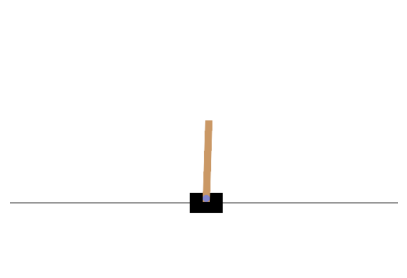

In [18]:
# extra code – creates a little function to render and plot an environment

def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)#Creates a new matplotlib figure with the size specified by size
    img = env.render()#Renders the env environment and stores the resulting image in the img variable
    plt.imshow(img)#Displays the image img in the matplotlib plot
    plt.axis("off")#Turns off the axes of the plot so that they are not displayed
    return img#Returns the rendered image so that it can be used or displayed outside the function if necessary

plot_environment(env)#Calls the plot_environment function with env environment to render the environment image
plt.show()# Shows the plot with the rendered image

Let's see how to interact with an environment. Your agent will need to select an action from an "action space" (the set of possible actions). Let's see what this environment's action space looks like:

In [19]:
env.action_space

Discrete(2)

Yep, just two possible actions: accelerate towards the left (0) or towards the right (1).

Since the pole is leaning toward the right (`obs[2] > 0`), let's accelerate the cart toward the right:

In [20]:
action = 1  # accelerate right
obs, reward, done, truncated, info = env.step(action)
obs

array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32)

Notice that the cart is now moving toward the right (`obs[1] > 0`). The pole is still tilted toward the right (`obs[2] > 0`), but its angular velocity is now negative (`obs[3] < 0`), so it will likely be tilted toward the left after the next step.

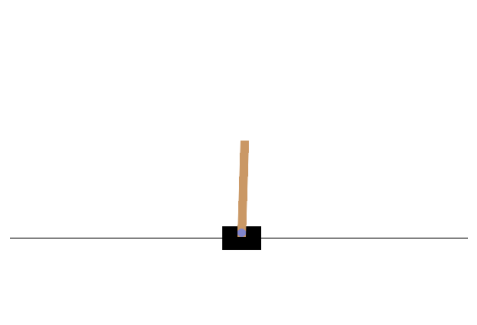

In [21]:
# extra code – displays the environment
plot_environment(env)
save_fig("cart_pole_plot")
plt.show()

Looks like it's doing what we're telling it to do!

The environment also tells the agent how much reward it got during the last step:

In [22]:
reward

1.0

When the game is over, the environment returns `done=True`. In this case, it's not over yet:

In [23]:
done

False

Some environment wrappers may want to interrupt the environment early. For example, when a time limit is reached or when an object goes out of bounds. In this case, `truncated` will be set to `True`. In this case, it's not truncated yet:

In [24]:
truncated

False

Finally, `info` is an environment-specific dictionary that can provide some extra information that you may find useful for debugging or for training. For example, in some games it may indicate how many lives the agent has.

In [25]:
info

{}

The sequence of steps between the moment the environment is reset until it is done or truncated is called an "episode". At the end of an episode (i.e., when `step()` returns `done=True` or `truncated=True`), you should reset the environment before you continue to use it.

In [26]:
if done or truncated:
    obs, info = env.reset()

Now how can we make the poll remain upright? We will need to define a _policy_ for that. This is the strategy that the agent will use to select an action at each step. It can use all the past actions and observations to decide what to do.

# A simple hard-coded policy

Let's hard code a simple strategy: if the pole is tilting to the left, then push the cart to the left, and _vice versa_. Let's see if that works:

In [62]:
def basic_policy(obs): #Defines the function politica_basica that takes an observation obs and returns the action to take
    angle = obs[2]#Extracts the pole angle from the cart-pole of the observation obs
    return 0 if angle < 0 else 1 #Returns 0 if the angle is negative indicating that the pole is tilted to the left 
#and 1 otherwise indicating that the pole is tilted to the right

totals = []#Creates an empty totals list to store the accumulated rewards for each episode
for episode in range(500):#Iterate over 500 episodes
    episode_rewards = 0#Initializes the variable rewards_episode to store the accumulated reward of each episode
    obs, info = env.reset(seed=episode)#Resets the environment for a new episode
    #using the episode number as the seed for reproducibility
    for step in range(200):#Iterates over a maximum of 200 steps in each episode
        action = basic_policy(obs)#Uses the politica_basica function to choose an action based on the current observation
        obs, reward, done, truncated, info = env.step(action)#Takes the chosen action in the environment 
        #and gets the next observation, the reward, whether the episode is finished
        #whether the episode has been truncated and additional information from the environment
        episode_rewards += reward #Accumulates the reward of the current step to the total rewards of the episode
        if done or truncated: #Checks if the episode has finished or has been truncated.
            break

    totals.append(episode_rewards) #Adds the total reward of the episode to the totals list

In [63]:
import numpy as np #"is the fundamental package for scientific 
#computing in Python. It is a Python library that provides a multidimensional 
#array object, various derived objects (such as masked arrays and matrices), 
#and an assortment of routines for fast operations on arrays, including mathematical, 
#logical, shape manipulation, sorting, selecting, I/O, 
#discrete Fourier transforms, basic linear algebra, 
#basic statistical operations, random simulation and much more" by (DevDocs.io).

np.mean(totals), np.std(totals), min(totals), max(totals)
'''
np.mean(totals) Calculates the mean of the values in the totals list, using NumPy's mean function.

np.std(totals) Calculates the standard deviation of the values in the totals list, using NumPy's std function

min(totals) Finds the minimum value in the totals list, using Python's min function.

max(totals) Finds the maximum value in the totals list, using the max Python function.
'''

"\nnp.mean(totals) Calculates the mean of the values in the totals list, using NumPy's mean function.\n\nnp.std(totals) Calculates the standard deviation of the values in the totals list, using NumPy's std function\n\nmin(totals) Finds the minimum value in the totals list, using Python's min function.\n\nmax(totals) Finds the maximum value in the totals list, using the max Python function.\n"

Well, as expected, this strategy is a bit too basic: the best it did was to keep the poll up for only 63 steps. This environment is considered solved when the agent keeps the poll up for 200 steps.

Let's visualize one episode. You can learn more about Matplotlib animations in the [Matplotlib tutorial notebook](tools_matplotlib.ipynb#Animations).

In [64]:
# extra code – this cell displays an animation of one episode
def update_scene(num, frames, patch): #Defines a function that updates the animation scene at each frame
    #It takes the current frame number, the list of frames and the image patch
    patch.set_data(frames[num])# Updates the patch data with the image of the current frame
    return patch,

def plot_animation(frames, repeat=False, interval=40): #Defines a function that creates the animation
    #it takes a list of frames
    #a boolean to indicate whether to repeat the animation and the interval between frames
    fig = plt.figure()#Creates a new figure from matplotlib
    patch = plt.imshow(frames[0])# Creates the initial image using the first frame in the list
    plt.axis('off')# Turns off the axes of the graph
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    ##Creates the animation using matplotlib's FuncAnimation function, which calls update_scene on each frame
    plt.close()#Closes the figure to prevent it from being displayed in the output
    return anim

def show_one_episode(policy, n_max_steps=200, seed=42):#Defines a function that displays an episode 
    #from the environment using a given policy. It takes the policy
    #the maximum number of steps per episode and a seed for random number generation
    frames = []#Initializes an empty list to store the frames of the episode
    env = gym.make("CartPole-v1", render_mode="rgb_array")#Creates an instance of the CartPole-v1 environment with RGB rendering mode
    np.random.seed(seed)#Sets the seed for NumPy's random number generator to ensure reproducibility
    obs, info = env.reset(seed=seed)#Resets the environment and gets the initial observation and additional information
    for step in range(n_max_steps):
        frames.append(env.render())##Adds the current frame to the list of frames
        action = policy(obs)#Uses the given policy to determine the action to take based on the current observation
        obs, reward, done, truncated, info = env.step(action)#Performs the action in the environment and receives 
        #the following observation, reward completion flag (finished), truncation flag, and additional information
        if done or truncated:#Checks if the episode has finished or has been truncated
            break#Exits the loop if the episode has finished or has been truncated
    env.close()#Closes the environment
    return plot_animation(frames) #Creates and displays the animation using 
#the plot_animacion function with the list of frames

show_one_episode(basic_policy)



Clearly the system is unstable and after just a few wobbles, the pole ends up too tilted: game over. We will need to be smarter than that!

# Neural Network Policies

Let's create a neural network that will take observations as inputs, and output the probabilities of actions to take for each observation. To choose an action, the network will estimate a probability for each action, then we will select an action randomly according to the estimated probabilities. In the case of the CartPole environment, there are just two possible actions (left or right), so we only need one output neuron: it will output the probability `p` of the action 0 (left), and of course the probability of action 1 (right) will be `1 - p`.

In [41]:
import tensorflow as tf
# Import the TensorFlow package in Python. TensorFlow is an open source machine learning library developed by Google. 
# It allows you to build and train machine learning models, such as neural networks
#for a variety of tasks, such as classification, regression, natural language processing, and more by chatgpt

tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])
'''
tf.random.set_seed(42): Sets the seed for the TensorFlow random number generator. This ensures that the results are reproducible, at least on the CPU

model = tf.keras.Sequential([...]): Creates a sequential neural network model using the Sequential high-level API of tf.keras, which allows stacking layers on top of each other sequentially

tf.keras.layers.Dense(5, activation="relu"): Adds a dense layer with 5 units and activation function ReLU to the neural network. A dense layer (fully connected) connects all neurons of the previous layer with those of the current layer

tf.keras.layers.Dense(1, activation="sigmoid"): Adds a dense layer with 1 unit and sigmoid activation function
This layer produces a binary output (0 or 1) since the sigmoid activation function compresses the output to a range between 0 and 1, useful for binary classification problems
'''

'\ntf.random.set_seed(42): Sets the seed for the TensorFlow random number generator. This ensures that the results are reproducible, at least on the CPU\n\nmodel = tf.keras.Sequential([...]): Creates a sequential neural network model using the Sequential high-level API of tf.keras, which allows stacking layers on top of each other sequentially\n\ntf.keras.layers.Dense(5, activation="relu"): Adds a dense layer with 5 units and activation function ReLU to the neural network. A dense layer (fully connected) connects all neurons of the previous layer with those of the current layer\n\ntf.keras.layers.Dense(1, activation="sigmoid"): Adds a dense layer with 1 unit and sigmoid activation function\nThis layer produces a binary output (0 or 1) since the sigmoid activation function compresses the output to a range between 0 and 1, useful for binary classification problems\n'

In this particular environment, the past actions and observations can safely be ignored, since each observation contains the environment's full state. If there were some hidden state then you may need to consider past actions and observations in order to try to infer the hidden state of the environment. For example, if the environment only revealed the position of the cart but not its velocity, you would have to consider not only the current observation but also the previous observation in order to estimate the current velocity. Another example is if the observations are noisy: you may want to use the past few observations to estimate the most likely current state. Our problem is thus as simple as can be: the current observation is noise-free and contains the environment's full state.

You may wonder why we plan to pick a random action based on the probability given by the policy network, rather than just picking the action with the highest probability. This approach lets the agent find the right balance between _exploring_ new actions and _exploiting_ the actions that are known to work well. Here's an analogy: suppose you go to a restaurant for the first time, and all the dishes look equally appealing so you randomly pick one. If it turns out to be good, you can increase the probability to order it next time, but you shouldn't increase that probability to 100%, or else you will never try out the other dishes, some of which may be even better than the one you tried.

Let's write a small policy function that will use the neural net to get the probability of moving left, then let's use it to run one episode:

In [25]:
# extra code – a function that creates an animation for a given policy model

def pg_policy(obs):#Defines a function politica_pg that takes an observation obs and returns an action 
    #(0 or 1) using the model (model) trained earlier in the code
    left_proba = model.predict(obs[np.newaxis], verbose=0)[0][0]#Uses the model model to predict the probability 
    #of moving left given obs. The observation obs is converted into a format suitable for the model using 
    #obs[np.newaxis] and the probability of class 0 (left) of the model is obtained
    return int(np.random.rand() > left_proba)#Returns 0 if a generated random number (np.random.rand()) is greater 
#than prob_left, which is the probability of moving left according to the model. Otherwise, it returns 1


np.random.seed(42)# Sets the seed for the NumPy random number generator to ensure that the random number sequence is reproducible.
show_one_episode(pg_policy)#Calls the show_an_episode function to show an episode of the CartPole-v1 environment using the politica_pg policy


Yeah... pretty bad. The neural network will have to learn to do better. First let's see if it is capable of learning the basic policy we used earlier: go left if the pole is tilting left, and go right if it is tilting right.

Let's see if it can learn a better policy on its own. One that does not wobble as much.

# Policy Gradients

To train this neural network we will need to define the target probabilities **y**. If an action is good we should increase its probability, and conversely if it is bad we should reduce it. But how do we know whether an action is good or bad? The problem is that most actions have delayed effects, so when you win or lose points in an episode, it is not clear which actions contributed to this result: was it just the last action? Or the last 10? Or just one action 50 steps earlier? This is called the _credit assignment problem_.

The _Policy Gradients_ algorithm tackles this problem by first playing multiple episodes, then making the actions near positive rewards slightly more likely, while actions near negative rewards are made slightly less likely. First we play, then we go back and think about what we did.

Let's start by creating a function to play a single step using the model. We will also pretend for now that whatever action it takes is the right one, so we can compute the loss and its gradients. We will just save these gradients for now, and modify them later depending on how good or bad the action turned out to be.

In [26]:
def play_one_step(env, obs, model, loss_fn): #executes an interaction step with the environment for a given model
    with tf.GradientTape() as tape:#Starts a gradient tape context everything that happens within this context 
        #will be logged so that TensorFlow can automatically calculate gradients
        left_proba = model(obs[np.newaxis])# Calculates the probability of moving left 
        #using the model model for the observation obs. obs[np.newaxis] converts the observation 
        #into the appropriate format for the model
        action = (tf.random.uniform([1, 1]) > left_proba)# Generates a random action (action) based on the probability 
        #of moving left (prob_left). If a uniformly generated 
        #random number is greater than prob_left, the action will be 1; otherwise, it will be 0
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)#Calculates the target (y_target) for the model
        #if action is 1, target is 0; if action is 0, target is 1
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))# Calculates the loss using the loss function  
        #between the target y_goal and the probability of moving left problef

    grads = tape.gradient(loss, model.trainable_variables)#Calculates the gradients of the loss with respect to the model's trainable variables
    obs, reward, done, truncated, info = env.step(int(action)) #Executes the action in the environment and obtains the new
    return obs, reward, done, truncated, grads


If `left_proba` is high, then `action` will most likely be `False` (since a random number uniformally sampled between 0 and 1 will probably not be greater than `left_proba`). And `False` means 0 when you cast it to a number, so `y_target` would be equal to 1 - 0 = 1. In other words, we set the target to 1, meaning we pretend that the probability of going left should have been 100% (so we took the right action).

Now let's create another function that will rely on the `play_one_step()` function to play multiple episodes, returning all the rewards and gradients, for each episode and each step:

In [27]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    #This code block defines a function play_multiple_episodes that plays multiple episodes 
    #in an environment using a given model. Here is what each line does by chatgpt
    all_rewards = []#Initialize empty lists to store rewards and gradients for all episodes
    all_grads = []#Initialize empty lists to store rewards and gradients for all episodes
    for episode in range(n_episodes):#Iterate over the specified number of episodes (n_episodes)
        current_rewards = []#Initialize empty lists to store the rewards and gradients for the current episode.
        current_grads = []#Initialize empty lists to store the rewards and gradients for the current episode.
        obs, info = env.reset()#Resets the environment and gets the initial observation and other information
        for step in range(n_max_steps):#Iterates over the maximum number of steps per episode (n_max_steps)
            obs, reward, done, truncated, grads = play_one_step(
                env, obs, model, loss_fn)
            ##executes a step of the game using the play_one_step function 
            #and gets the new observation, reward, completion and truncation flags, and gradients
            current_rewards.append(reward)#Append the reward and gradients of the current step to the current episode's lits
            current_grads.append(grads)#Append the reward and gradients of the current step to the current episode's lits
            if done or truncated:
                break

        all_rewards.append(current_rewards)#Append the current episode's lists of rewards and gradients to the lists of all rewards and gradients
        all_grads.append(current_grads)##Append the current episode's lists of rewards and gradients to the lists of all rewards and gradients

    return all_rewards, all_grads #Returns all rewards and gradients for all episodes

The Policy Gradients algorithm uses the model to play the episode several times (e.g., 10 times), then it goes back and looks at all the rewards, discounts them and normalizes them. So let's create couple functions for that: the first will compute discounted rewards; the second will normalize the discounted rewards across many episodes.

In [28]:
def discount_rewards(rewards, discount_factor):##Defines a function called rewards_discounted that takes a list of rewards
    ##rewards and a discount factor discount_factor
    discounted = np.array(rewards)#Creates an array of NumPy from the rewards to be able to perform calculations on them
    for step in range(len(rewards) - 2, -1, -1): # Iterates over the time steps in reverse order (from len(rewards)-2 to 0) 
        #to calculate the discounted rewards
        discounted[step] += discounted[step + 1] * discount_factor#Calculates the discounted reward for the 
        #current time step by adding the current reward with the discounted reward of the next step multiplied by the discount factor.

    return discounted#Returns the list of discounted rewards

def discount_and_normalize_rewards(all_rewards, discount_factor):#Defines a function called discount_and_normalize-rewards 
    #that takes a list of reward lists (all_rewards) and a discount factor (discount_factor).

    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]3    #Calculates the discounted rewards for each rewards list 
    #in all-rewards using the rewards-discounted_rewards function defined above.

    flat_rewards = np.concatenate(all_discounted_rewards)#Concatenates all discounted rewards lists into a single list
    reward_mean = flat_rewards.mean() #Calculates the mean of all discounted reward
    reward_std = flat_rewards.std()#Calculates the standard deviation of all discounted rewards
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards] #Normalizes the discounted rewards by subtracting the mean 
#and dividing by the standard deviation Returns a list of normalized reward lists


Say there were 3 actions, and after each action there was a reward: first 10, then 0, then -50. If we use a discount factor of 80%, then the 3rd action will get -50 (full credit for the last reward), but the 2nd action will only get -40 (80% credit for the last reward), and the 1st action will get 80% of -40 (-32) plus full credit for the first reward (+10), which leads to a discounted reward of -22:

In [29]:
discount_rewards([10, 0, -50], discount_factor=0.8)

array([-22, -40, -50])

To normalize all discounted rewards across all episodes, we compute the mean and standard deviation of all the discounted rewards, and we subtract the mean from each discounted reward, and divide by the standard deviation:

In [30]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]],
                               discount_factor=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [31]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

In [32]:
# extra code – let's create the neural net and reset the environment, for
#              reproducibility

tf.random.set_seed(42) #Sets the seed for the TensorFlow random number generator
#his ensures that random operations in TensorFlow, such as initializing weights in the model
#produce the same results every time the code is run


model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])#Creates a sequential neural network model using the Sequential high-level API of tf.keras
#the model consists of two dense (fully connected) layers
#he first layer has 5 units and uses the ReLU activation function
#and the second layer has 1 unit and uses the sigmoidal activation function


obs, info = env.reset(seed=42)# Resets the env environment and gets the initial observation and other 
#information using a specific seed (42 in this case to ensure that the environment 
#restarts the same way every time the code is executed


In [33]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01) ##creates a Nadam optimizer  with a learning 
#rate of 0.01 The Nadam optimizer combines the Adam algorithm with the Nesterov correction
#which can improve convergence in some situations
loss_fn = tf.keras.losses.binary_crossentropy#defines a loss function using the binary crossentropy
#this loss function is commonly used in binary classification problems, where the objective is to predict 
#a binary output (0 or 1) binary cross entropy is used to measure the discrepancy between the 
#predicted and actual probability distributions

In [34]:
for iteration in range(n_iterations): #Itera sobre el número de iteraciones especificado n_iteraciones
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
#Play multiple episodes in the environment and save all rewards and gradients obtained during the game

    # extra code – displays some debug info during training
    total_rewards = sum(map(sum, all_rewards))# Calculates the total of all rewards earned in all episodes played in this iteration.

    print(f"\rIteration: {iteration + 1}/{n_iterations},"
          f" mean rewards: {total_rewards / n_episodes_per_update:.1f}", end="")
# Displays debugging information during training, including the curent iteration number and the average reward per episode
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_factor)#Discounts and normalizes all rewards earned in the episodes played in this iteration
    all_mean_grads = []#Discounts and normalizes all rewards earned in the episodes played in this iteration
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
# Calculates the average gradients for each trainable variable in the model using the gradients and normalized rewards

    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))#Applies the calculated average gradients to the model using the specified optimizer.


Iteration: 150/150, mean rewards: 191.9

In [35]:
# extra code – displays the animation
np.random.seed(42)
show_one_episode(pg_policy)

The following transition probabilities correspond to the Markov Chain represented in Figure 18–7. Let's run this stochastic process a few times to see what it looks like:

# Markov Decision Process

In [42]:
transition_probabilities = [  # shape=[s, a, s']
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
    [None, [0.8, 0.1, 0.1], None]
]
rewards = [  # shape=[s, a, s']
    [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
    [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
    [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]
]
possible_actions = [[0, 1, 2], [0, 2], [1]]

# Q-Value Iteration

In [43]:
Q_values = np.full((3, 3), -np.inf)  # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # for all possible actions

In [44]:
gamma = 0.90  # the discount factor

history1 = []  # extra code – needed for the figure below
for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev) # extra code
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * Q_prev[sp].max())
                for sp in range(3)])

history1 = np.array(history1)  # extra code

In [45]:
Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

In [46]:
Q_values.argmax(axis=1)  # optimal action for each state

array([0, 0, 1], dtype=int64)

# Q-Learning

Q-Learning works by watching an agent play (e.g., randomly) and gradually improving its estimates of the Q-Values. Once it has accurate Q-Value estimates (or close enough), then the optimal policy consists in choosing the action that has the highest Q-Value (i.e., the greedy policy).

We will need to simulate an agent moving around in the environment, so let's define a function to perform some action and get the new state and a reward:

In [47]:
#por lo mismo ya no documente la ultima parte, perdia mucho tiempo en ello antes de que lo cambiara
#esto esta extra 
#ignorar de aca en adelante 
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

We also need an exploration policy, which can be any policy, as long as it visits every possible state many times. We will just use a random policy, since the state space is very small:

In [48]:
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

Now let's initialize the Q-Values like earlier, and run the Q-Learning algorithm:

In [49]:
# extra code – initializes the Q-Values, just like earlier
np.random.seed(42)
Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state][actions] = 0

In [50]:
alpha0 = 0.05  # initial learning rate
decay = 0.005  # learning rate decay
gamma = 0.90  # discount factor
state = 0  # initial state
history2 = []  # extra code – needed for the figure below

for iteration in range(10_000):
    history2.append(Q_values.copy())  # extra code
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = Q_values[next_state].max()  # greedy policy at the next step
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

history2 = np.array(history2)  # extra code

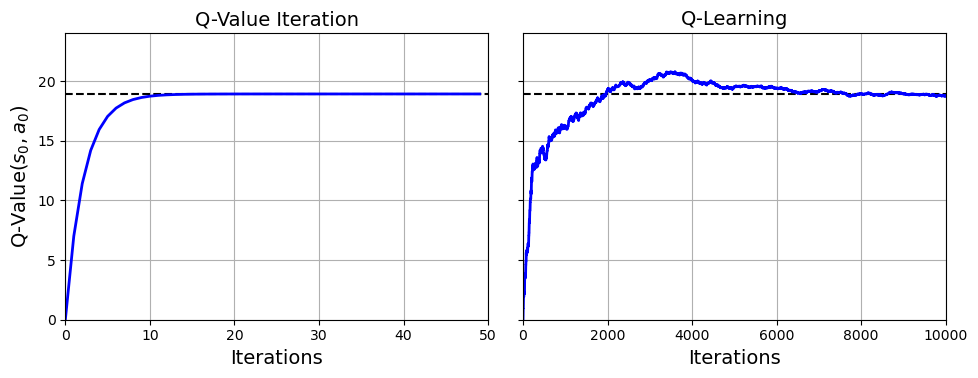

In [51]:
# extra code – this cell generates and saves Figure 18–9

true_Q_value = history1[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])
    ax.grid(True)

save_fig("q_value_plot")
plt.show()

#puede que salga

In [66]:
#hecho en su totalidad por una inteligenica articifial 
#, por lo mismo ya no documente la ultima parte, perdia mucho tiempo en ello antes de que lo cambiara
# Define the CartPole environment
env = gym.make('CartPole-v1')

# Define the number of states and actions
n_states = 10**4
n_actions = env.action_space.n

# Define the learning parameters
alpha = 0.1
gamma = 0.99
epsilon = 0.1

# Define the discretization function
def discretize(obs):
    obs = np.asarray(obs).flatten()
    obs = obs[:4]  # Only use the first 4 elements of the observation
    upper_bounds = [env.observation_space.high[0], 0.5, env.observation_space.high[2], np.radians(50)/1.]
    lower_bounds = [env.observation_space.low[0], -0.5, env.observation_space.low[2], -np.radians(50)/1.]
    ratios = (obs + np.abs(lower_bounds)) / (upper_bounds - lower_bounds)
    new_obs = [int(np.round((n_states-1)*x)) for x in ratios]
    new_obs = [min(n_states-1, max(0, x)) for x in new_obs]
    return tuple(new_obs)

def policy(state, Q):
    if np.random.uniform() < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(Q[state])

Q = np.zeros((n_states, n_actions))
history = []
for i in range(10000):
    obs = env.reset()
    state = discretize(np.array(obs))  # Convert obs to NumPy array before passing to discretize
    done = False
    while not done:
        action = policy(state, Q)
        obs, reward, done, info = env.step(action)
        next_state = discretize(np.array(obs))  # Convert obs to NumPy array before passing to discretize
        Q[state][action] += alpha * (reward + gamma*np.max(Q[next_state]) - Q[state][action])
        state = next_state

        history.append(env.render(mode='rgb_array'))

env.close()

fig = plt.figure()
plt.axis("off")
ims = [[plt.imshow(im, animated=True)] for im in history]
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
plt.show()


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.